In [3]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=3)


In [4]:
## count number of inclusions - brute force
def inclusions(E):
    counts = np.zeros((len(E)-1,len(E)-1), dtype=int)
    for i in range(0,len(E)-1):
        for j in range(i+1,len(E)):
            for a in E[i]:
                for b in E[j]:
                    if a.issubset(b):
                        counts[i,j-1] +=1
    return counts 

## naive CL function - simple HG
## from nodes, generate num_edges unique edges of size=size
def naive_CL(nodes, num_edges, size):
    CL = []
    ctr = 0
    L = len(nodes)
    while ctr < num_edges:
        x = set([nodes[x] for x in np.random.randint(0,L,size)])
        if len(x)!=size:
            while len(x)!=size:
                x = set([nodes[x] for x in np.random.randint(0,L,size)])
        if x not in CL:
            CL.append(x)
            ctr += 1
    return CL

## Computer 4 matrices of counts for node inclusions (for a chosen dataset)

* GT: using ground-truth edges
* CL: using Chung-Lu generated edges (if REP>1, take average)
* GT_lower: for sizes i<j, size-i edges are from GT, size j from CL (if REP>1, take average)
* GT_upper: for sizes i<j, size-j edges are from GT, size i from CL (if REP>1, take average)


In [39]:
REP = 3
MAXSIZE = 10

## read edge list
with open('../hospital-lyon-simple.txt', 'r') as file:
    for line in file:
        if line.strip() == 'edges':
            break
    edges = []
    for line in file:
        line = line.strip().strip('{}').replace('\'','').split(', ')
        if len(line)<=MAXSIZE:
            edges.append(line)


In [40]:
## edge sizes
sizes = [len(x) for x in edges]
min_size = np.min(sizes)
max_size = np.max(sizes)

## save GT edges by size in increasing order and compute inclusions
Edges = [[]]*(max_size+1)
for s in range(min_size,max_size+1):
    Edges[s] = [set(x) for x in edges if len(x)==s]
GT = inclusions([E for E in Edges if len(E)>0])

## generate CL edges by size in increasing order and compute (average) inclusions
CL = np.zeros(GT.shape)
GT_lower = np.zeros(GT.shape)
GT_upper = np.zeros(GT.shape)
nodes = [node for edge in edges for node in edge]

for rep in range(REP):
    A = [[]]*(max_size+1)
    for s in range(min_size,max_size+1):
        if len(Edges[s])>0:
            A[s] = naive_CL(nodes, len(Edges[s]), s)
    CL += inclusions([E for E in A if len(E)>0])
    
    ## compute two more arrays: GT_lower and GT_upper
    ## lower: for all i<j, i is from GT hypergraph (rest from CL)
    ## upper: for all i<j, j is from GT hypergraph (rest from CL)
    GT_l = np.zeros(GT.shape)
    GT_u = np.zeros(GT.shape)

    for i in range(min_size,max_size+1):
        X = []
        for j in range(min_size,max_size+1):
            if i==j:
                X.append(Edges[i])
            else:
                X.append(A[j])
        I = inclusions(X)
        ## fill row i for GT_lower (except i==np.max(Lens)) and col i-1 for GT_upper (except i==np.min(Lens))
        if i < max_size:
            GT_l[i-min_size] = I[i-min_size]
        if i > min_size:
            GT_u[i-min_size-1] = I.transpose()[i-min_size-1]
    GT_lower += GT_l
    GT_upper += GT_u.transpose()
    
CL = CL/REP
GT_lower = GT_lower/REP
GT_upper = GT_upper/REP


In [41]:
print('Edge size range:',min_size,max_size,'\n')
print('Ground Truth:\n',GT,'\n\nChung-Lu:\n',CL,'\n\nGround Truth Lower:\n',GT_lower,
      '\n\nGround Truth Upper:\n',GT_upper)

Edge size range: 2 5 

Ground Truth:
 [[1938  347   20]
 [   0  190   12]
 [   0    0    0]] 

Chung-Lu:
 [[1426.667  243.667   13.   ]
 [   0.      11.333    1.333]
 [   0.       0.       0.   ]] 

Ground Truth Lower:
 [[1406.     245.667   14.   ]
 [   0.      15.333    1.333]
 [   0.       0.       0.   ]] 

Ground Truth Upper:
 [[1636.333  324.667   20.   ]
 [   0.      27.       3.667]
 [   0.       0.       0.   ]]


## All datasets - row sums

In [50]:
datasets = ['NDC-substances-simple.txt',
'contact-high-school-simple.txt',
'contact-primary-school-simple.txt',
'diseasome-simple.txt',
'disgenenet-simple.txt',
'email-enron-simple.txt',
'email-eu-simple.txt',
'hospital-lyon-simple.txt',
'tags-ask-ubuntu-simple.txt',
'tags-math-sx-simple.txt',
'congress-bills-simple.txt']

In [55]:
REP = 5
MAXSIZE = 10
ROWS = []

## read edge list
for ds in datasets:
    print(ds)
    with open('../'+ds, 'r') as file:
        for line in file:
            if line.strip() == 'edges':
                break
        edges = []
        for line in file:
            line = line.strip().strip('{}').replace('\'','').split(', ')
            if len(line)<=MAXSIZE:
                edges.append(line)

    ## edge sizes
    sizes = [len(x) for x in edges]
    min_size = np.min(sizes)
    max_size = np.max(sizes)

    ## save GT edges by size in increasing order and compute inclusions
    Edges = [[]]*(max_size+1)
    for s in range(min_size,max_size+1):
        Edges[s] = [set(x) for x in edges if len(x)==s]
    GT = inclusions([E for E in Edges if len(E)>0])

    ## generate CL edges by size in increasing order and compute (average) inclusions
    CL = np.zeros(GT.shape)
    GT_lower = np.zeros(GT.shape)
    GT_upper = np.zeros(GT.shape)
    nodes = [node for edge in edges for node in edge]

    for rep in range(REP):
        A = [[]]*(max_size+1)
        for s in range(min_size,max_size+1):
            if len(Edges[s])>0:
                A[s] = naive_CL(nodes, len(Edges[s]), s)
        CL += inclusions([E for E in A if len(E)>0])

        ## compute two more arrays: GT_lower and GT_upper
        ## lower: for all i<j, i is from GT hypergraph (rest from CL)
        ## upper: for all i<j, j is from GT hypergraph (rest from CL)
        GT_l = np.zeros(GT.shape)
        GT_u = np.zeros(GT.shape)

        for i in range(min_size,max_size+1):
            X = []
            for j in range(min_size,max_size+1):
                if i==j:
                    X.append(Edges[i])
                else:
                    X.append(A[j])
            I = inclusions(X)
            ## fill row i for GT_lower (except i==np.max(Lens)) and col i-1 for GT_upper (except i==np.min(Lens))
            if i < max_size:
                GT_l[i-min_size] = I[i-min_size]
            if i > min_size:
                GT_u[i-min_size-1] = I.transpose()[i-min_size-1]
        GT_lower += GT_l
        GT_upper += GT_u.transpose()

    CL = CL/REP
    GT_lower = GT_lower/REP
    GT_upper = GT_upper/REP

    ## ratio of row sums
    l = np.arange(min_size,max_size+1)
    gt = GT.sum(axis=1)
    cl = CL.sum(axis=1)
    gt_l = GT_lower.sum(axis=1)
    gt_u = GT_upper.sum(axis=1)
    for i in range(len(gt)):
        if gt[i]>0:
            ROWS.append([ds,l[i],gt[i],cl[i],gt_l[i],gt_u[i],(gt[i]-cl[i])/gt[i],
                   (gt[i]-gt_l[i])/gt[i],(gt[i]-gt_u[i])/gt[i]])

df = pd.DataFrame(ROWS, columns=['dataset','size','gt','CL','gt_lower','gt_upper',
                                      'ratio','ratio_lower','ratio_upper'])
df.head()


NDC-substances-simple.txt
contact-high-school-simple.txt
contact-primary-school-simple.txt
diseasome-simple.txt
disgenenet-simple.txt
email-enron-simple.txt
email-eu-simple.txt
hospital-lyon-simple.txt
tags-ask-ubuntu-simple.txt
tags-math-sx-simple.txt
congress-bills-simple.txt


,dataset,size,gt,CL,gt_lower,gt_upper,ratio,ratio_lower,ratio_upper
0,NDC-substances-simple.txt,1,18737,20881.8,19174.4,21585.6,-0.114469,-0.023344,-0.152031
1,NDC-substances-simple.txt,2,3911,700.2,664.6,1402.4,0.820967,0.830069,0.641422
2,NDC-substances-simple.txt,3,1310,6.6,10.4,20.6,0.994962,0.992061,0.984275
3,NDC-substances-simple.txt,4,443,0.0,0.6,0.6,1.000000,0.998646,0.998646
4,NDC-substances-simple.txt,5,120,0.0,0.0,0.0,1.000000,1.000000,1.000000


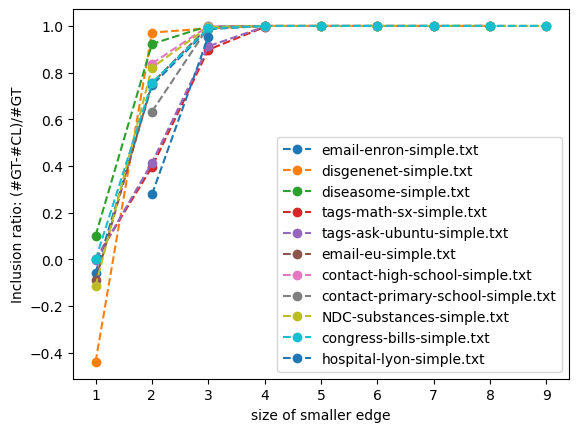

In [56]:
DS = set(df['dataset'])
for ds in DS:
    D = df[df['dataset']==ds]
    plt.plot(D['size'],D['ratio'],'o--',label=ds,alpha=1)
plt.xlabel('size of smaller edge')
plt.ylabel('Inclusion ratio: (#GT-#CL)/#GT')
plt.legend();

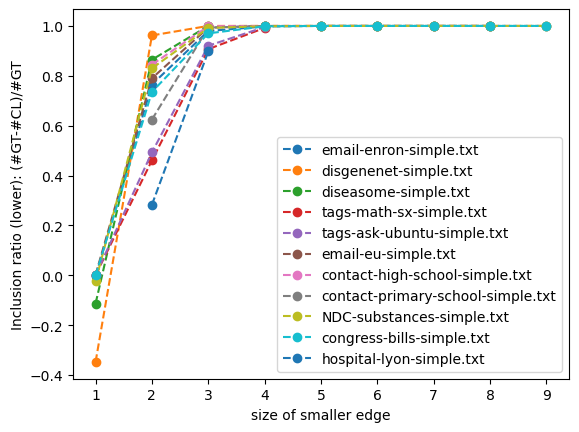

In [57]:
DS = set(df['dataset'])
for ds in DS:
    D = df[df['dataset']==ds]
    plt.plot(D['size'],D['ratio_lower'],'o--',label=ds,alpha=1)
plt.xlabel('size of smaller edge')
plt.ylabel('Inclusion ratio (lower): (#GT-#CL)/#GT')
plt.legend();

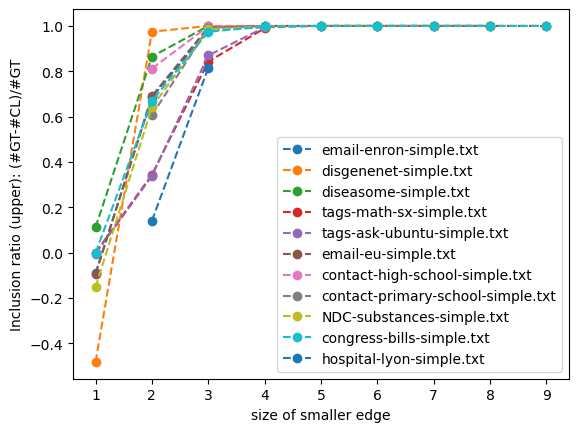

In [58]:
DS = set(df['dataset'])
for ds in DS:
    D = df[df['dataset']==ds]
    plt.plot(D['size'],D['ratio_upper'],'o--',label=ds,alpha=1)
plt.xlabel('size of smaller edge')
plt.ylabel('Inclusion ratio (upper): (#GT-#CL)/#GT')
plt.legend();